# Impacts of rising atmospheric CO<sub>2</sub> on tree growth: What do the experiments indicate?

Robbie A Hember, Forest Carbon Modeller

Climate Change and Integrated Planning Branch,<br>
Office of the Chief Forester,<br>
Forests Lands, Natural Resource Operations and Rural Development<br>
Government of British Columbia<br>
545 Superior Street, Victoria, Canada<br>
Robert.Hember@gov.bc.ca

2020-03-17

## Background and Objectives

Scientific research can help answer many questions facing forest resource management, but distilling the available evidence down to a straightforward sentence, or a single number, or a categorical "yes" or "no" answer is often challenging. Take the question: Is rising atmospheric concentration of carbon dioxide (CO<sub>2</sub>) increasing tree growth? Many experiments have been performed to address the question, and there are now many studies that also summarize the response found in those experiments. Yet, collectively, they don't seem to provide a clear numerical answer.
Here, I briefly summarize available CO<sub>2</sub> experiments with the purpose of report a statistical description of CO<sub>2</sub> responses found in enrichment experiments. It is followed by a short summary of qualifying statements about how the statistics could be misused or misinterpreted, and finally a list of essential literature on the subject. 

The analysis was restricted in scope to help narrow the focus of the study. First, our interest is primarily in forests, so focus was placed on summarizing experiments that were conducted on trees. Second, our interest was much more in effects on biomass production than photosynthesis, so the analysis was limited to describing the response of effects on woody biomass. 

![title](https://i.cbc.ca/1.4805536.1535665109!/fileImage/httpImage/image.jpg_gen/derivatives/original_1180/spruce-exterior.jpg)
Experiment near London, Ontario (www.cbc.ca/news/canada/london/climate-change-western-spruce-boreal-1.4805029).

## Prepare Session
First load the python packages that we need to complete the analysis and prepare this session in Jupyter Notebooks.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy.matlib
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Data

For this analysis, we will draw on data that were already compiled and analyzed by several peer-reviewed studies. These data were copied from tables or the appendix of publications and pasted into a single spreadsheet database. For each experiment, they have compiled the mean CO<sub>2</sub> concentration for the control (i.e., the ambient CO<sub>2</sub> concentration at the time of the experiment was performed) and the treatment (i.e., the enriched level of CO<sub>2</sub> concentration that they chose to expose plants to). 

Let's load database into a dataframe.

In [37]:
df=pd.read_excel(r'E:\Data\CO2EnrichmentExperiments\CO2EnrichmentExperiments.xlsx')
df=df[df['Summary']=='Summary']
df=df.reset_index()

The database contains a summary of experiments performed on seedlings (Wullschleger et al. 1995), open-grown trees (Norby et al. 1999), and entire forest plots (Calfapietra et al 2003; Norby et al. 2010; Bader et al. 2013; Talhelm et al. 2014; Klein et al. 2014; Kim et al. 2019). 

First, let's extract the seedling-specific results from Wullschleger et al. (1995) and have a look. 

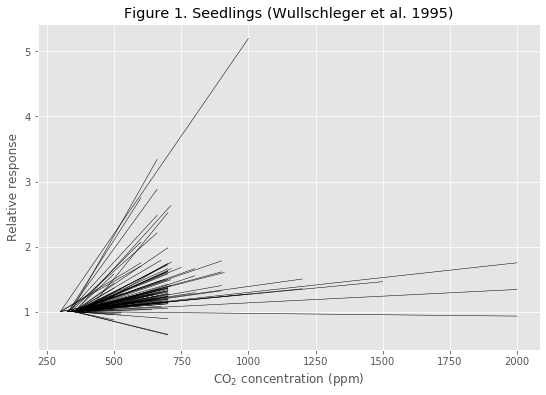

In [38]:
fig,ax=plt.subplots(1,figsize=(9,6))
for i in range(len(df)):
    if df.loc[i,'Source']=='Wullschleger et al. 1995':       
        ax.plot([df.loc[i,'CO2_A'],df.loc[i,'CO2_E']],[1,df.loc[i,'RR']],'-k',linewidth=0.5)
ax.set(xlabel='CO$_2$ concentration (ppm)',ylabel='Relative response',
       title='Figure 1. Seedlings (Wullschleger et al. 1995)');

The experimental responses of biomass are all expressed in a relative scale, where a value of 1.0 always corresponds to biomass for the control CO<sub>2</sub> concentration, and the response ratio indicates the change relative to 1.0 at the treatment CO$_2$ concentration. So a response ratio of 2 indicates a 100% response above the control biomass. (Sometimes this is also referred to as a one-fold increase, but that terminology can get confusing so we stick with the convention of response ratios.) 

These results correspond to tree seedlings. Recognizing that results could be more representative of seedlings than trees in other stages of development, a later study by Norby et al. (1999) compiled results for open-grown field trees. Let's have a look.

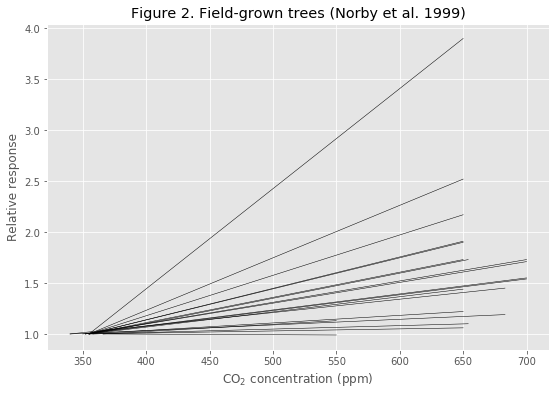

In [39]:
fig,ax=plt.subplots(1,figsize=(9,6))
for i in range(len(df)):
    if df.loc[i,'Source']=='Norby et al. 1999':
        ax.plot([df.loc[i,'CO2_A'],df.loc[i,'CO2_E']],[1,df.loc[i,'RR']],'-k',linewidth=0.5)
ax.set(xlabel='CO$_2$ concentration (ppm)',ylabel='Relative response',
       title='Figure 2. Field-grown trees (Norby et al. 1999)');

The experiments that were conducted at the scale of entire forest plots use a technology called, free-air carbon dioxide enrichment (FACE). The experiments emerged to help understand whether responses to CO<sub>2</sub> concentration found in chamber-level experiments held at the scale of forest ecosystems.

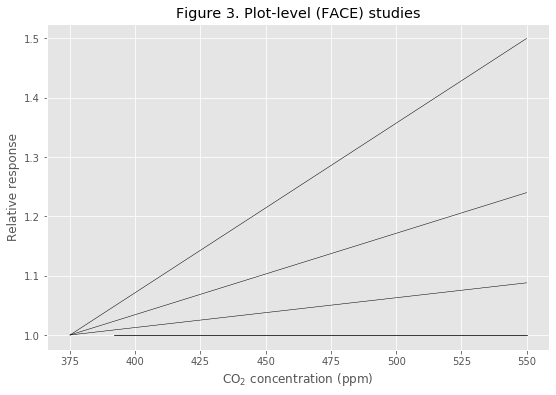

In [40]:
fig,ax=plt.subplots(1,figsize=(9,6))
for i in range(len(df)):
    if (df.loc[i,'FACE']=='FACE'):
        ax.plot([df.loc[i,'CO2_A'],df.loc[i,'CO2_E']],[1,df.loc[i,'RR']],'-k',linewidth=0.5)
ax.set(xlabel='CO$_2$ concentration (ppm)',ylabel='Relative response',
       title='Figure 3. Plot-level (FACE) studies');

## Methods
A fundamental step in analyzing any dataset is to simply tabulate descriptive statics - indicators that tell you basic properties of the data, including sample size, measures of central tendency and variation. However, because the conditions in each experiment differ, there are some hoops to jump through just to achieve this basic step. 

The problem, specifically, is that the experiments differ in the CO<sub>2</sub> concentration of both the control and treatment. Differences in control CO<sub>2</sub> concentration are inevitable given that it depends on what the abient (atmospheric) concentration was the year the experiment was performed. And atmospheric CO<sub>2</sub> was, of course, increasing over the time in which the experiments were conducted. 

Ambient levels of CO<sub>2</sub> concentration ranged from:

In [41]:
print(str(df['CO2_A'].min()) + ' to ' + str(df['CO2_A'].max()) + ' (ppm)')

300.0 to 400.0 (ppm)


while , treatment levels of CO<sub>2</sub> concentration ranged from:

In [42]:
print(str(df['CO2_E'].min()) + ' to ' + str(df['CO2_E'].max()) + ' (ppm)')

415.0 to 2000.0 (ppm)


Let's standardize the relative responses to CO<sub>2</sub> concentration so that we can pool the experiments together and calculate descriptive statistics. To do this, we need choose a reference CO<sub>2</sub> concentration level. Then we need to fit a predictive function to the data for each experiment, and then use that predictive function to extrapolate back to the reference level. The ambient CO<sub>2</sub> concentration before humans started to significantly impact it is thought to be approximately 280 ppm, so let's assume that as the reference level. We know that the response of photosynthesis to CO<sub>2</sub> concentration is nonlinear at the scale of individual leaves. At the scale of whole plants, the response is also commonly assumed to be nonlinar. The response of biomass is commonly described by a logarithmic function.

In [43]:
rs={}
rs['co2_ref']=280
rs['co2']=np.arange(rs['co2_ref'],1000,1)

In [44]:
def LogFunc(x,b1,b2):
    return b1*(1+b2*np.log(x/280))

We will fit a logarithmic function to the results from each experiment and look at an example of how the function works. Let's save the fitted response for a wide range in CO<sub>2</sub> concentration, recognizing that predictions beyond the range of the experiment are an extrapolation.

In [45]:
rs['b_opt']=np.nan*np.ones((len(df),2))
rs['yhat']=np.nan*np.ones((rs['co2'].size,len(df)))
rs['yhat_ex']=np.nan*np.ones((len(df),2))
for i in range(len(df)):
    x=np.array([df.loc[i,'CO2_A'],df.loc[i,'CO2_E']])
    y=np.array([1,df.loc[i,'RR']])
    try:
        p,pcov=curve_fit(LogFunc,x,y)   
        rs['b_opt'][i,:]=p
        rs['yhat'][:,i]=LogFunc(rs['co2'],p[0],p[1])
        rs['yhat_ex'][i,:]=LogFunc(x,p[0],p[1])
    except:
        pass            

Confirm that the fitted curve reproduces the experimental results exactly.

In [46]:
print('Mean difference between given RR and fitted estimate = ' + 
      str(np.round(np.mean(df['RR']-rs['yhat_ex'][:,1]),decimals=3)))

Mean difference between given RR and fitted estimate = -0.0


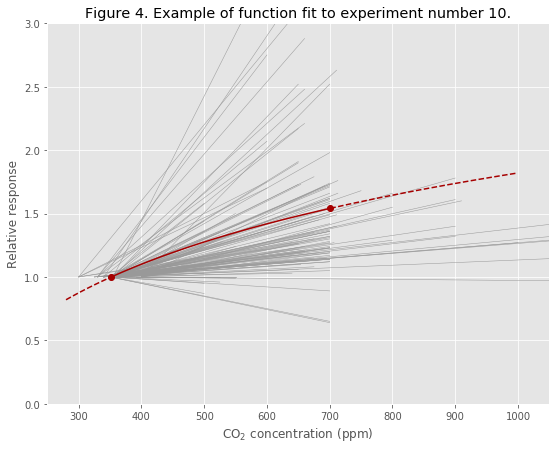

In [47]:
iExample=10
fig,ax=plt.subplots(1,figsize=(9,7))
for i in range(len(df)):
    ax.plot([df.loc[i,'CO2_A'],df.loc[i,'CO2_E']],[1,df.loc[i,'RR']],'-k',color=[0.6,0.6,0.6],linewidth=0.5)
ax.set(xlim=[250,1050],xlabel='CO$_2$ concentration (ppm)',ylim=[0,3],ylabel='Relative response',
      title='Figure 4. Example of function fit to experiment number 10.');
ax.plot([df.loc[iExample,'CO2_A'],df.loc[iExample,'CO2_E']],[1,df.loc[iExample,'RR']],'ro',color=[0.65,0,0])
iInsideRange=np.where( (rs['co2']>=df.loc[iExample,'CO2_A']) & (rs['co2']<=df.loc[iExample,'CO2_E']) )[0]
ax.plot(rs['co2'][iInsideRange],rs['yhat'][iInsideRange,iExample],'r-',color=[0.65,0,0])
iBelow=np.where( (rs['co2']<df.loc[iExample,'CO2_A']) )[0]
iAbove=np.where( (rs['co2']>df.loc[iExample,'CO2_E']) )[0]
ax.plot(rs['co2'][iBelow],rs['yhat'][iBelow,iExample],'r--',color=[0.65,0,0])
ax.plot(rs['co2'][iAbove],rs['yhat'][iAbove,iExample],'r--',color=[0.65,0,0]);

Now we can standardize all the experiments by simply dividing each fitted curve by the reference level CO<sub>2</sub> concentration.

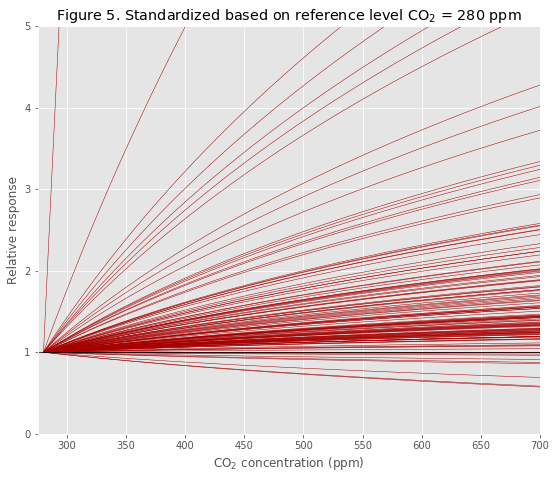

In [48]:
iRef=np.where(rs['co2']==rs['co2_ref'])[0]
rs['yhat_z']=rs['yhat']/np.matlib.repmat(rs['yhat'][iRef,:],rs['co2'].size,1)

fig,ax=plt.subplots(1,figsize=(9,7.5))
for i in range(len(df)):
    ax.plot(rs['co2'],rs['yhat_z'][:,i],'r-',color=[0.65,0,0],linewidth=0.5)
ax.plot([275,700],[1,1],'k-',linewidth=0.75)
ax.set(xlim=[275,700],xlabel='CO$_2$ concentration (ppm)',ylim=[0,5],ylabel='Relative response',
       title='Figure 5. Standardized based on reference level CO$_2$ = 280 ppm');

There are a few experiments that indicate extreme response ratios. Let's use 2 x S.D. as a rough threshold to define outliers and exclude these anomalous results from the calculation of descriptive statistics.

In [49]:
co2_today=400
rs['rr400']=rs['yhat_z'][rs['co2']==co2_today,:].flatten()
th_Outlier=2*np.nanstd(rs['rr400'])
df['Outlier']=np.zeros(len(df))
df.loc[rs['rr400']>th_Outlier,'Outlier']=1
rs['yhat_z_or']=rs['yhat_z'].copy()
rs['rr400_or']=rs['rr400'].copy()
rs['yhat_z_or'][:,df['Outlier']==1]=np.nan
rs['rr400_or'][df['Outlier']==1]=np.nan
print(str(df['Outlier'].sum()) + ' experiments excluded because they were deemed to be outliers.')

1.0 experiments excluded because they were deemed to be outliers.


## Results

Following standardization across a a wide range in CO<sub>2</sub> concentration, we can now tabulate descriptive statistics. We chose here to focus on what the experiments suggest ought to have occurred as CO<sub>2</sub> concentration increased from 280 ppm to 400 ppm, corresponding roughly with the change that occurred between the onset of the industrial revolution and today. 

In [52]:
ds={'Sample size (N)':np.sum(~np.isnan(rs['rr400_or'])),
    'Mean':np.round(np.nanmean(rs['rr400_or']),2),
    'Median':np.round(np.nanmedian(rs['rr400_or']),2),
    'Standard deviation (S.D.)':np.round(np.nanstd(rs['rr400_or']),2),
   'Standard error (S.E.)':np.round(np.nanstd(rs['rr400_or'])/np.sqrt(np.sum(~np.isnan(rs['rr400_or']))),2)}
df2=pd.DataFrame.from_dict(ds,orient='index')
print('Table 1. Descriptive statistics (response between 280 and 400 ppm).')
print(df2)

Table 1. Descriptive statistics (response between 280 adn 400 ppm).
                                0
Sample size (N)            130.00
Mean                         1.35
Median                       1.18
Standard deviation (S.D.)    0.52
Standard error (S.E.)        0.05


Finally, let's create a graphical summary of the descriptive statistics.

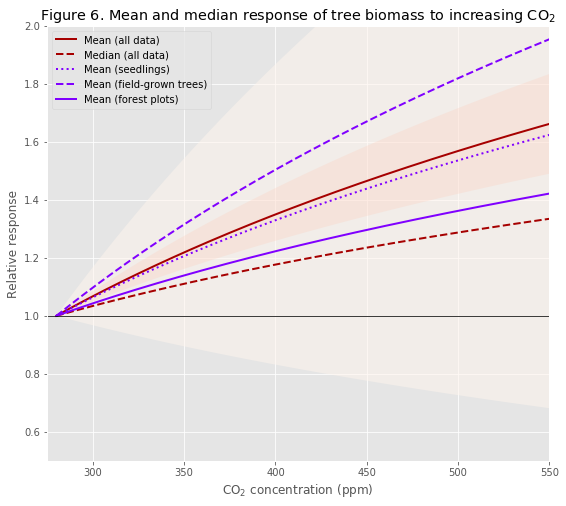

In [50]:
N_all=np.sum(~np.isnan(rs['yhat_z_or'][0,:]))
mu_all=np.nanmean(rs['yhat_z_or'],axis=1)
sd_all=np.nanstd(rs['yhat_z_or'],axis=1)
sig2_all=2*sd_all/np.sqrt(N_all)
med_all=np.nanmedian(rs['yhat_z_or'],axis=1)
mu_Seedling=np.nanmean(rs['yhat_z_or'][:,df['Source']=='Wullschleger et al. 1995'],axis=1)
mu_FieldGrown=np.nanmean(rs['yhat_z_or'][:,df['Source']=='Norby et al. 1999'],axis=1)
mu_Plot=np.nanmean(rs['yhat_z_or'][:,df['FACE']=='FACE'],axis=1)

fig,ax=plt.subplots(1,figsize=(9,8))
ax.fill_between(rs['co2'],mu_all-sd_all,mu_all+sd_all,color=[1,0.96,0.93],alpha=0.5,linewidth=0)    
ax.fill_between(rs['co2'],mu_all-sig2_all,mu_all+sig2_all,color=[1,0.78,0.7],alpha=0.25,linewidth=0)    
p0=ax.plot(rs['co2'],mu_all,'k-',color=[0.65,0,0],linewidth=2)
p1=ax.plot(rs['co2'],med_all,'k--',color=[0.65,0,0],linewidth=2)

p2=ax.plot(rs['co2'],mu_Seedling,'k:',color=[0.5,0,1],linewidth=2)
p3=ax.plot(rs['co2'],mu_FieldGrown,'k--',color=[0.5,0,1],linewidth=2)
p4=ax.plot(rs['co2'],mu_Plot,'k-',color=[0.5,0,1],linewidth=2)

ax.plot([275,1050],[1,1],'k-',linewidth=0.75)
ax.set(xlim=[275,550],xlabel='CO$_2$ concentration (ppm)',ylim=[0.5,2],ylabel='Relative response',
       title='Figure 6. Mean and median response of tree biomass to increasing CO$_2$');
ax.legend((p0[0],p1[0],p2[0],p3[0],p4[0]),['Mean (all data)','Median (all data)','Mean (seedlings)',
        'Mean (field-grown trees)','Mean (forest plots)'],loc='upper left');

## Conclusions

By standardizing the results from 130 CO<sub>2</sub> enrichment trials using a logaritmic function fit to each experiment, the mean response of aboveground tree biomass increased by a factor of 1.35 (or 35%) as atmospheric CO<sub>2</sub> increased from 280 to 400 ppm. Adopting 2 x S.E. (10%) as a rough indicator of the 95-percent confidence interval, we can report that both the mean and median response of aboveground biomass are significantly greater than zero. 

With a standard deviation (52%) that exceeds the mean response (35%), we can say that there is large variability in the responses to CO<sub>2</sub> enrichment. With a median response (18%) that is substantially lower than the mean response, we can also safely conclude that the distribution of responses to CO<sub>2</sub> concentration are signficantly skewed. That is, the overall mean response is affected by a relatively small number of disproportionately strong responses. 

Although these results strongly support the hypothesis that increasing atmospheric CO<sub>2</sub> is, on average, accelerating the growth rate of trees by 35%, it is not safe to assume that forest biomes are growing 35% faster. The reasons for this include: 

1) The response from experiments approximately represents the marginal response to CO<sub>2</sub>, while the actual changes in tree growth as ambient CO<sub>2</sub> increased will ultimately depend on the net impact of many factors, including CO<sub>2</sub>; 

2) Negative feedback mechanisms will _partially_ counteract the direct stimulus of individual trees from increasing CO<sub>2</sub> (Norby et al. 1999; Körner 2006; Bugmann and Bigler 2011; Hember and Kurz 2018). Forests are ultra-competitive communities and increasing growth of trees increases competition for resources and accelerates the self-thinning process. Increased tree growth leads to bigger trees, and tree species tend to have finite limits on how big they can get. For example, the two experiments in forests older than 100 years-old report no significant response (Bader et al. 2013; Klein et al. 2016); 

3) Finally, forest disturbances also act as negative feedbacks, as a large proportion of those (faster-growing) trees still burn in wildfires, still get harvested in clearcuts, and still get munched on by beetles and budworms. All these feedback mechanisms deminish the CO<sub>2</sub> effect, but there is no evidence to suggest that they entirely counteract the effect.

Does a 35% increase in tree growth suggest that a "wall of wood is coming"? No. Should the positive response of tree growth to CO<sub>2</sub> be ignored in modelling and analysis of forest resources? No.

## References

Bader, M.K.-F., Leuzinger, S., Keel, S.G., Siegwolf, R.T.W., Hagedorn, F., Schleppi, P., Körner, C., 2013. Central European hardwood trees in a high-CO₂ future: synthesis of an 8-year forest canopy CO₂ enrichment project. J Ecol 101, 1509–1519. https://doi.org/10.1111/1365-2745.12149.

Bugmann, H., Bigler, C., 2011. Will the CO₂ fertilization effect in forests be offset by reduced tree longevity? Oecologia 165, 533–544. https://doi.org/10.1007/s00442-010-1837-4

Calfapietra, C., Gielen, B., Galema, A.N.J., Lukac, M., De Angelis, P., Moscatelli, M.C., Ceulemans, R., Scarascia-Mugnozza, G., 2003. Free-air CO2 enrichment (FACE) enhances biomass production in a short-rotation poplar plantation. Tree Physiol 23, 805–814. https://doi.org/10.1093/treephys/23.12.805.

Hember, R.A., Kurz, W.A., 2018. Low tree-growth elasticity of forest biomass indicated by an individual-based model. Forests 9, 21. https://doi.org/10.3390/f9010021.

Kim, D., Medvigy, D., Maier, C.A., Johnsen, K., Palmroth, S., 2019. Biomass increases attributed to both faster tree growth and altered allometric relationships under long-term carbon dioxide enrichment at a temperate forest. Global Change Biology n/a. https://doi.org/10.1111/gcb.14971.

Klein, T., Bader, M.K.-F., Leuzinger, S., Mildner, M., Schleppi, P., Siegwolf, R.T.W., Körner, C., 2016. Growth and carbon relations of mature Picea abies trees under 5 years of free-air CO2 enrichment. J Ecol 104, 1720–1733. https://doi.org/10.1111/1365-2745.12621.

Körner, C., 2006. Plant CO₂ responses: an issue of definition, time and resource supply. New Phytologist 172, 393–411. https://doi.org/10.1111/j.1469-8137.2006.01886.x

Norby, R., Wullschleger, S., Gunderson, C., Johnson, D., Ceulemans, R., 1999. Tree responses to rising CO₂ in field experiments: implications for the future forest. Plant Cell and Environment 22, 683–714. https://doi.org/10.1046/j.1365-3040.1999.00391.x.

Saxe, H., Ellsworth, D.S., Heath, J., 1998. Tree and forest functioning in an enriched CO₂ atmosphere. New Phytologist 139, 395–436. https://doi.org/10.1046/j.1469-8137.1998.00221.x.

Talhelm, A.F., Pregitzer, K.S., Kubiske, M.E., Zak, D.R., Campany, C.E., Burton, A.J., Dickson, R.E., Hendrey, G.R., Isebrands, J.G., Lewin, K.F., Nagy, J., Karnosky, D.F., 2014. Elevated carbon dioxide and ozone alter productivity and ecosystem carbon content in northern temperate forests. Global Change Biology 20, 2492–2504. https://doi.org/10.1111/gcb.12564.

Wullschleger, S.D., Post, W.M., King, A.W., (eds) Woodwell, G.M., Mackenzie, F.T., 1995. On the potential role for CO₂ fertilization effect in forests: Estimates of the biotic growth factor based on 58 controlled-exposure studies, in: Biotic Feedbacks in the Global Climatic System: Will the Warming Feed the Warming? Oxford University Press.

## Chronology of Review Studies

Acock, B., Allen, L.H., 1985. Crop responses to elevated carbon dioxide concentration, in: Direct Effects of Increasing Carbon Dioxide on Vegetation, DOE/ER-0238. US Dept. of Energy, Carbon Dioxide Res. Div., Washington DC, pp. 53–97.

Stitt, M., 1991. Rising CO₂ levels and their potential significance for carbon flow in photosynthetic cells. Plant, Cell & Environment 14, 741–762. https://doi.org/10.1111/j.1365-3040.1991.tb01440.x.

Gifford, R.M., 1992. Interaction of Carbon Dioxide with Growth-Limiting Environmental Factors in Vegetation Productivity: Implications for the Global Carbon Cycle, in: Advances in Bioclimatology, Advances in Bioclimatology. Springer Berlin Heidelberg, pp. 24–58.

Poorter, H., 1993. Interspecific variation in the growth response of plants to an elevated ambient CO₂ concentration. Vegetatio 104/105, 76–97.

Wullschleger, S., 1993. Biochemical Limitations to Carbon Assimilation in C(3) Plants - a Retrospective Analysis of the a/Ci Curves from 109 Species. Journal of Experimental Botany 44, 907–920.

Rozema, J., Lambers, H., Van de Geijn, S.C., Cambridge, M.L., 1993. CO2 and biosphere, Advances in vegetation science.
Saxe, H., Ellsworth, D.S., Heath, J., 1998. Tree and forest functioning in an enriched CO₂ atmosphere. New Phytologist 139, 395–436. https://doi.org/10.1046/j.1469-8137.1998.00221.x

Idso, K.E., Idso, S.B., 1994. Plant responses to atmospheric CO₂ enrichment in the face of environmental constraints: a review of the past 10 years’ research. Agricultural and Forest Meteorology 69, 153–203. https://doi.org/10.1016/0168-1923(94)90025-6.

Drake, B.G., Gonzàlez-Meler, M.A., Long, S.P., 1997. More efficient plants: a consequence of rising atmospheric co2? Annual Review of Plant Physiology and Plant Molecular Biology 48, 609–639. https://doi.org/10.1146/annurev.arplant.48.1.609

Norby, R., Wullschleger, S., Gunderson, C., Johnson, D., Ceulemans, R., 1999. Tree responses to rising CO₂ in field experiments: implications for the future forest. Plant Cell and Environment 22, 683–714.

Körner, C., 2000. Biosphere responses to CO₂ enrichment. Ecological Applications 10, 1590–1619. https://doi.org/10.2307/2641226.

Poorter, H., Pérez-Soba, M., 2001. The growth response of plants to elevated CO₂ under non-optimal environmental conditions. Oecologia 129, 1–20. https://doi.org/10.1007/s004420100736.

Beedlow, P.A., Tingey, D.T., Phillips, D.L., Hogsett, W.E., Olszyk, D.M., 2004. Rising atmospheric CO2 and carbon sequestration in forests. Frontiers in Ecology and the Environment 2, 315–322. https://doi.org/10.1890/1540-9295(2004)002[0315:RACACS]2.0.CO;2.

Nowak, R.S., Ellsworth, D.S., Smith, S.D., 2004. Functional responses of plants to elevated atmospheric CO2– do photosynthetic and productivity data from FACE experiments support early predictions? New Phytologist 162, 253–280. https://doi.org/10.1111/j.1469-8137.2004.01033.x.

Körner, C., 2006. Plant CO₂ responses: an issue of definition, time and resource supply. New Phytologist 172, 393–411. https://doi.org/10.1111/j.1469-8137.2006.01886.x.

Reich, P.B., Hungate, B.A., Luo, Y., 2006. Carbon-Nitrogen Interactions in Terrestrial Ecosystems in Response to Rising Atmospheric Carbon Dioxide. Annual Review of Ecology, Evolution, and Systematics 37, 611–636. https://doi.org/10.1146/annurev.ecolsys.37.091305.110039.

Ainsworth, E., Rogers, A., 2007. The response of photosynthesis and stomatal conductance to rising [CO₂]: mechanisms and environmental interactions. Plant Cell and Environment 30, 258–270. https://doi.org/10.1111/j.1365-3040.2007.01641.x.

Leakey, A.D.B., Ainsworth, E.A., Bernacchi, C.J., Rogers, A., Long, S.P., Ort, D.R., 2009. Elevated CO2 effects on plant carbon, nitrogen, and water relations: six important lessons from FACE. J. Exp. Bot. 60, 2859–2876. https://doi.org/10.1093/jxb/erp096.

Norby, R.J., Zak, D.R., 2011. Ecological lessons from Free-Air CO₂ Enrichment (FACE) experiments. Annual Review of Ecology, Evolution, and Systematics 42, 181–203. https://doi.org/10.1146/annurev-ecolsys-102209-144647.

Franks, P.J., Adams, M.A., Amthor, J.S., Barbour, M.M., Berry, J.A., Ellsworth, D.S., Farquhar, G.D., Ghannoum, O., Lloyd, J., 
McDowell, N., Norby, R.J., Tissue, D.T., von Caemmerer, S., 2013. Sensitivity of plants to changing atmospheric CO₂ concentration: from the geological past to the next century. New Phytol 197, 1077–1094. https://doi.org/10.1111/nph.12104.

Kirschbaum, M.U.F., Lambie, S.M., 2015. Re-analysis of plant CO2 responses during the exponential growth phase: interactions with light, temperature, nutrients and water availability. Funct. Plant Biol. 42, 989–1000.

Allen, L.H., Kimball, B.A., Bunce, J.A., Yoshimoto, M., Harazono, Y., Baker, J.T., Boote, K.J., White, J.W., 2020. Fluctuations of CO2 in Free-Air CO2 Enrichment (FACE) depress plant photosynthesis, growth, and yield. Agricultural and Forest Meteorology 284, 107899. https://doi.org/10.1016/j.agrformet.2020.107899.